In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# cd only once to the wanted dir at the beginning
%cd '/content/drive/MyDrive/Grad School/ECE219/HW1'

Mounted at /content/drive
/content/drive/MyDrive/Grad School/ECE219/HW1


In [2]:
import pandas as pd
import numpy as np
import string
import collections
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
dataset = pd.read_csv("./Project1-Classification.csv")

# Question 1

In [4]:
print(f"There are {dataset.shape[0]} rows and {dataset.shape[1]} columns")

There are 3150 rows and 8 columns


In [5]:
for col in dataset.columns:
  print(col)

full_text
summary
keywords
publish_date
authors
url
leaf_label
root_label


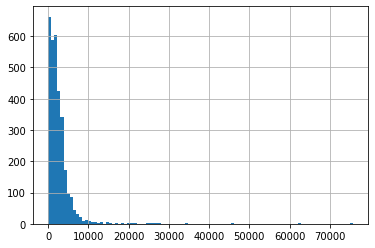

In [6]:
# Full Text
def calc_alphanum(x):
  alphanum = "abcdefghijklmnopqrstuvwxyz1234567890"
  counts = collections.Counter(x)
  uniques = set(x)
  return sum([counts[c] for c in uniques if c in alphanum])
new_col = dataset.full_text.apply(calc_alphanum)
new_col.hist(bins=100)

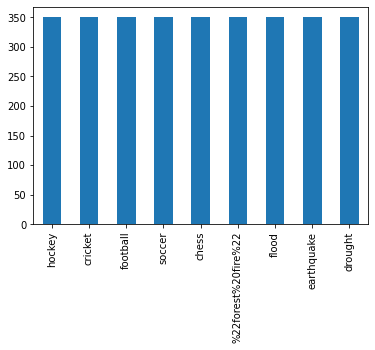

In [7]:
# Leaf Labels
dataset.leaf_label.value_counts().plot(kind='bar')

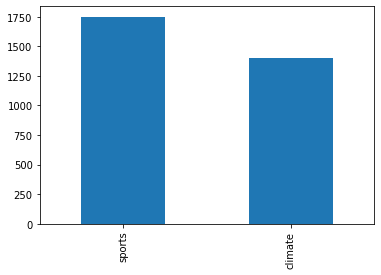

In [8]:
# Root Labels
dataset.root_label.value_counts().plot(kind='bar')

# Question 2

In [9]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset[["full_text","root_label", "leaf_label"]], test_size=0.2)
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [11]:
print(f"There are {train.shape[0]} train samples and {test.shape[0]} test samples")

There are 2520 train samples and 630 test samples


# Question 3

In [12]:
import re
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

In [13]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# clean using their function
cleaned_train = train.full_text.apply(clean)
cleaned_test = test.full_text.apply(clean)

# Remove punctuation and numbers
def preprocess(x):
  nums = "1234567890"
  for c in x:
    if c in string.punctuation or c in nums:
      x = x.replace(c, "")
  return x
cleaned_train = cleaned_train.apply(preprocess)
cleaned_test = cleaned_test.apply(preprocess)

# Tokenize
tokenized_train = cleaned_train.apply(nltk.word_tokenize)
tokenized_test = cleaned_test.apply(nltk.word_tokenize)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatize with PoS tagging
def lemma(sent):
  lemmatizer = WordNetLemmatizer()
  tagged = nltk.pos_tag(sent)
  res = []
  for word in tagged:
    pos = get_wordnet_pos(word[1])
    if pos:
      res.append(lemmatizer.lemmatize(word[0], pos=pos))
    else:
      res.append(lemmatizer.lemmatize(word[0]))
  # test = [lemmatizer.lemmatize(word[0], pos=get_wordnet_pos(word[1])) for word in tagged if get_wordnet_pos(word[1]) else lemmatizer.lemmatize(word[0])]
  return res

lemmatized_train = tokenized_train.apply(lemma)
lemmatized_test = tokenized_test.apply(lemma)


def stem(arr):
  stemmer = PorterStemmer()
  res = []
  for word in arr:
    res.append(stemmer.stem(word))
  return res

stemmed_train = tokenized_train.apply(stem)
stemmed_test = tokenized_test.apply(stem)

# Recreate sentences
def make_sent(x):
  return ' '.join(x)
final_data_train = lemmatized_train.apply(make_sent)
final_data_test = lemmatized_test.apply(make_sent)

final_data_train_stemmed = stemmed_train.apply(make_sent)
final_data_test_stemmed = stemmed_test.apply(make_sent)

# CountVectorizer
vectorizer = CountVectorizer(min_df=3, max_df=0.75, stop_words='english')
train_counts = vectorizer.fit_transform(final_data_train)
test_counts = vectorizer.transform(final_data_test)
print(train_counts.shape)
print(test_counts.shape)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


(2520, 15071)
(630, 15071)


In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(train_counts)
x_test_tfidf = tfidf_transformer.transform(test_counts)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(2520, 15071)
(630, 15071)


# Question 4

In [15]:
import scipy
# LSI
# Take SVD of tfidf matrix
# Multiply X * Vk
u, sigma, v = scipy.sparse.linalg.svds(x_train_tfidf, k=750)
dim_reduced_train = x_train_tfidf@(v.transpose())
reconstructed = u@(scipy.sparse.diags(sigma))@v

u, sigma, v = scipy.sparse.linalg.svds(x_test_tfidf, k=750)
dim_reduced_test = x_test_tfidf@(v.transpose())

mse = np.mean(np.sqrt(np.power(x_train_tfidf - reconstructed, 2)))
print(f"MSE for LSI is {mse}")

ValueError: ignored

In [26]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
W = nmf.fit_transform(x_train_tfidf)
H = nmf.components_
reconstructed = W@H

mse = np.mean(np.sqrt(np.power(x_train_tfidf - reconstructed, 2)))
print(f"MSE for NMF is {mse}")

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


MSE for NMF is 0.000934942230451941


# Question 5

In [27]:
from sklearn.svm import SVC

def label_data(x):
  if x == "sports":
    return 1
  else:
    return 0
train_labels = train.root_label.apply(label_data)
test_labels = test.root_label.apply(label_data)

hard_margin = SVC(C=1000, kernel='linear').fit(dim_reduced_train, train_labels)
soft_margin = SVC(C=0.0001, kernel='linear').fit(dim_reduced_train, train_labels)

[[ 50 213]
 [231 136]]
0.29523809523809524
0.38968481375358166
0.37988826815642457


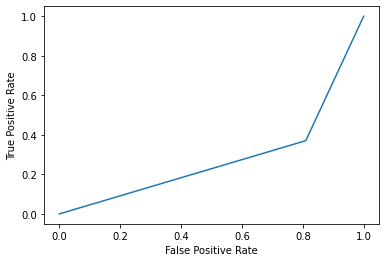

In [31]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, accuracy_score, precision_score, f1_score

hard_margin_pred = hard_margin.predict(dim_reduced_test)

fpr, tpr, thresholds = roc_curve(test_labels, hard_margin_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(confusion_matrix(test_labels, hard_margin_pred))
print(accuracy_score(test_labels, hard_margin_pred))
print(precision_score(test_labels, hard_margin_pred))
print(f1_score(test_labels, hard_margin_pred))

[[  0 263]
 [  0 367]]
0.5825396825396826
0.5825396825396826
0.7362086258776329


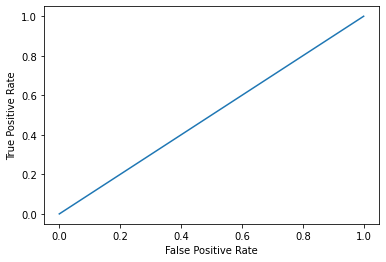

In [32]:
soft_margin_pred = soft_margin.predict(dim_reduced_test)

fpr, tpr, thresholds = roc_curve(test_labels, soft_margin_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(confusion_matrix(test_labels, soft_margin_pred))
print(accuracy_score(test_labels, soft_margin_pred))
print(precision_score(test_labels, soft_margin_pred))
print(f1_score(test_labels, soft_margin_pred))

In [34]:
from sklearn.model_selection import cross_val_score

gammas = [10**x for x in range(-3, 7)]
avg_accs = []
for gamma in gammas:
  classifier = SVC(C=gamma, kernel='linear', random_state=123).fit(dim_reduced_train, train_labels)
  scores = cross_val_score(classifier, dim_reduced_test, test_labels, cv=5)
  avg_accs.append(scores.mean())

print(avg_accs, np.argmax(avg_accs), np.max(avg_accs))

[0.5825396825396826, 0.5825396825396826, 0.8555555555555555, 0.9523809523809523, 0.9603174603174602, 0.9539682539682539, 0.9444444444444444, 0.9412698412698413, 0.9412698412698413, 0.9412698412698413] 4 0.9603174603174602


# Question 6

[[ 34 229]
 [235 132]]
0.2634920634920635
0.3656509695290859
0.3626373626373626


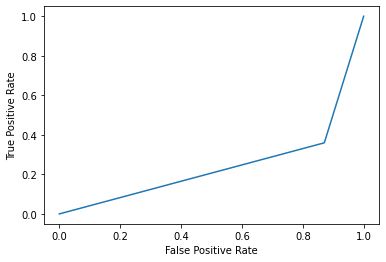

In [41]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2', C=2**30, solver='liblinear').fit(dim_reduced_train, train_labels)
preds = classifier.predict(dim_reduced_test)

fpr, tpr, thresholds = roc_curve(test_labels, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(confusion_matrix(test_labels, preds))
print(accuracy_score(test_labels, preds))
print(precision_score(test_labels, preds))
print(f1_score(test_labels, preds))

In [42]:
# L1 Regularization 
gammas = [10**x for x in range(-5, 6)]
accs = []
for gamma in gammas:
  classifier = LogisticRegression(penalty='l1', C=gamma, solver='liblinear', random_state=123)
  scores = cross_val_score(classifier, dim_reduced_test, test_labels, cv=5)
  accs.append(scores.mean())

indices = [x for x in range(-5, 6)]
print(indices[np.argmax(accs)])

1


In [43]:
# L2 Regularization
gammas = [10**x for x in range(-5, 6)]
accs = []
for gamma in gammas:
  classifier = LogisticRegression(penalty='l2', C=gamma, solver='liblinear', random_state=123)
  scores = cross_val_score(classifier, dim_reduced_test, test_labels, cv=5)
  accs.append(scores.mean())

indices = [x for x in range(-5, 6)]
print(indices[np.argmax(accs)])

2


# Question 7

[[ 54 209]
 [266 101]]
0.24603174603174602
0.3258064516129032
0.2983751846381093


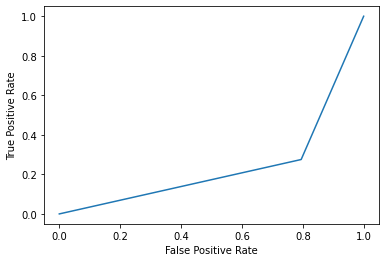

In [45]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB().fit(dim_reduced_train, train_labels)
preds = classifier.predict(dim_reduced_test)

fpr, tpr, thresholds = roc_curve(test_labels, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(confusion_matrix(test_labels, preds))
print(accuracy_score(test_labels, preds))
print(precision_score(test_labels, preds))
print(f1_score(test_labels, preds))

# Question 8

In [46]:
total_runs = 2*2*2*3*4
print(total_runs)

96


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

class DataProcessingTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, use_lemma=True):
    self.use_lemma = use_lemma
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    cleaned = X.full_text.apply(clean)
    processed = cleaned.apply(preprocess)
    tokenized = processed.apply(nltk.word_tokenize)
    if self.use_lemma:
      compressed = tokenized.apply(lemma)
    else:
      pass
    transformed = compressed.apply(make_sent)
    return transformed.to_numpy()

class DimRedTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, use_lsi=True, num_features=50):
    self.use_lsi = True
    self.num_features = num_features

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    if self.use_lsi:
      u, sigma, v = scipy.sparse.linalg.svds(X, k=self.num_features)
      return X@(v.transpose())
    else:
      nmf = NMF(n_components=self.num_features)
      W = nmf.fit_transform(X)
      return W

steps = [#('preprocessing', DataProcessingTransformer()),
         ('vectorizing', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('dim_red', DimRedTransformer()),
         ('classifier', SVC())]

params = [
    {
        'vectorizing__min_df': (3, 5),
        'vectorizing__stop_words': ('english',),
        'dim_red__use_lsi': (True, False),
        'dim_red__num_features': (5, 30, 80),
        'classifier': (SVC(),),
        'classifier__C': (10**1,),
        'classifier__kernel': ('linear',)
    },
    {
        'vectorizing__min_df': (3, 5),
        'vectorizing__stop_words': ('english',),
        'dim_red__use_lsi': (True, False),
        'dim_red__num_features': (5, 30, 80),
        'classifier': (LogisticRegression(),),
        'classifier__C': (10**1,),
        'classifier__kernel': ('linear',),
        'classifier__penalty': ('l1',)
    },
    {
        'vectorizing__min_df': (3, 5),
        'vectorizing__stop_words': ('english',),
        'dim_red__use_lsi': (True, False),
        'dim_red__num_features': (5, 30, 80),
        'classifier': (LogisticRegression(),),
        'classifier__C': (10**2),
        'classifier__kernel': ('linear',),
        'classifier__penalty': ('l2',)
    },
    {
        'vectorizing__min_df': (3, 5),
        'vectorizing__stop_words': ('english',),
        'dim_red__use_lsi': (True, False),
        'dim_red__num_features': (5, 30, 80),
        'classifier': (GaussianNB(),)
    }
]

params_test = [
    {
        'vectorizing__min_df': [3, 5],
        'vectorizing__stop_words': ('english',),
        'dim_red__use_lsi': [True],
        'dim_red__num_features': [5],
        'classifier': [SVC()],
        'classifier__C': [10**1],
        'classifier__kernel': ['linear']
    }
]

pipe = Pipeline(steps=steps)
scores = []
for input in [final_data_train, final_data_train_stemmed]:
  search = GridSearchCV(pipe, params_test, n_jobs=2) # change to params instead of params_test to run on full grid
  search.fit(input, train_labels)
  scores.append(search.best_score_)
print(scores)

# Question 9

In [37]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, accuracy_score, recall_score, precision_score, f1_score


def label_data(x):
  label_map = {
      "chess":0,
      "cricket":1,
      "hockey":2,
      "soccer":3,
      "football":4,
      "%22forest%20fire%22":5,
      "flood":6,
      "earthquake":7,
      "drought":8
  }
  return label_map[x]

multi_train_labels = train.leaf_label.apply(label_data)
multi_test_labels = test.leaf_label.apply(label_data)

ovr = OneVsRestClassifier(SVC(kernel='linear')).fit(dim_reduced_train, multi_train_labels)
preds = ovr.predict(dim_reduced_test)
print(confusion_matrix(multi_test_labels, preds))
print(accuracy_score(multi_test_labels, preds))
print(recall_score(multi_test_labels, preds, average='weighted'))
print(precision_score(multi_test_labels, preds, average='weighted'))
print(f1_score(multi_test_labels, preds, average='weighted'))

ovo = OneVsOneClassifier(SVC(kernel='linear')).fit(dim_reduced_train, multi_train_labels)
preds = ovo.predict(dim_reduced_test)
print(confusion_matrix(multi_test_labels, preds))
print(accuracy_score(multi_test_labels, preds))
print(recall_score(multi_test_labels, preds, average='weighted'))
print(precision_score(multi_test_labels, preds, average='weighted'))
print(f1_score(multi_test_labels, preds, average='weighted'))

nb = GaussianNB().fit(dim_reduced_train, multi_train_labels)
preds = nb.predict(dim_reduced_test)
print(confusion_matrix(multi_test_labels, preds))
print(accuracy_score(multi_test_labels, preds))
print(recall_score(multi_test_labels, preds, average='weighted'))
print(precision_score(multi_test_labels, preds, average='weighted'))
print(f1_score(multi_test_labels, preds, average='weighted'))

[[21 27  9  0  0 16  2  0  1]
 [ 6  0  2  0  0  2 29  4 28]
 [ 6 48  0  0  0  9  1  3  2]
 [16  0 29  0  2  6  1 14  2]
 [22  4 23  0  3  3  0 12  2]
 [ 4 19 16  0  0  2 19  2  5]
 [21  0  0  0  0  1  2  1 42]
 [ 3  6  1  0  0  1  9 44  1]
 [ 5  1  1  0  0  6 55  0  8]]
0.12698412698412698
0.12698412698412698
0.1638509670255117
0.11726662060368769


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[17 18  0  2  0 37  0  1  1]
 [ 1  0  0  0  0 35  0 28  7]
 [29  0  0  0  0 38  0  1  1]
 [12  0  8  8  6 31  0  4  1]
 [23  2  4  6  8 22  0  4  0]
 [ 4  0 12  5  0 35  5  3  3]
 [15  0  0  0  0 14  0  1 37]
 [ 1  0  0  0  0 20  2 41  1]
 [ 6  0  0  0  0 36 27  0  7]]
0.18412698412698414
0.18412698412698414
0.20331595013689568
0.15493045620446855
[[19  0  3 23  8  3  0 20  0]
 [ 0  0  0 40  4  0  2 12 13]
 [ 0  0  7 25 29  2  0  3  3]
 [ 1  0  9 23 32  4  0  1  0]
 [ 0  0  5 24 32  1  0  7  0]
 [ 8  0  0 10  7 10  2 10 20]
 [ 0  0  0  1  1  6 11  2 46]
 [ 0  0  0  6  4  3  0 51  1]
 [ 1  0  0  4  0 13 14  2 42]]
0.30952380952380953
0.30952380952380953
0.3122333803823131
0.27557812678346033


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Question 10

a. not sure

b. They would give different GLoVE embeddings since they are used in context of different words. GLoVE isi trained using co-occurrence probabilities so this would create different vectors when different pairs of words occur.

c. First should be close to 0, second should be close to third

d. lemmatize since this often creates real words rather than word fragments

# Question 11

a. get the GLoVE vector for each word in the sentence, then average these vectors to get the feature

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_train_and_test(embeddings):
  # clean using their function
  cleaned_train = train.full_text.apply(clean)
  cleaned_test = test.full_text.apply(clean)

  embeddings_dict = {}
  dimension_of_glove = 300
  with open(embeddings, 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector


  def get_glove(sent):
    vec = None
    count = 0
    for word in sent.split():
      if count == 0 and word in embeddings_dict:
        vec = embeddings_dict[word]
        count += 1
      elif word in embeddings_dict:
        vec += embeddings_dict[word]
        count += 1
    return vec / count

  vectorized_train = cleaned_train.apply(get_glove).to_numpy()
  vectorized_train = np.stack(vectorized_train, axis=0)
  vectorized_train = np.clip(vectorized_train, -1, 1)

  vectorized_test = cleaned_test.apply(get_glove).to_numpy()
  vectorized_test = np.stack(vectorized_test, axis=0)
  vectorized_test = np.clip(vectorized_test, -1, 1)
  return vectorized_train, vectorized_test

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
vectorized_train, vectorized_test = get_train_and_test("glove.6B.300d.txt")

In [26]:
print(vectorized_train.shape, vectorized_test.shape)

(2520, 300) (630, 300)


In [27]:
print(np.min(vectorized_train), np.max(vectorized_train))


-1.0 1.0


In [28]:
from sklearn.svm import SVC

def label_data(x):
  if x == "sports":
    return 1
  else:
    return 0
train_labels = train.root_label.apply(label_data)
test_labels = test.root_label.apply(label_data)

hard_margin = SVC(C=10, kernel='linear').fit(vectorized_train, train_labels)

[[  0 263]
 [  0 367]]
0.5825396825396826
0.5825396825396826
0.7362086258776329


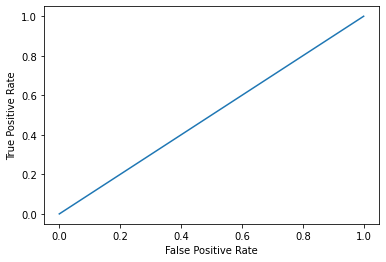

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, accuracy_score, precision_score, f1_score

preds = hard_margin.predict(vectorized_test)

fpr, tpr, thresholds = roc_curve(test_labels, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(confusion_matrix(test_labels, preds))
print(accuracy_score(test_labels, preds))
print(precision_score(test_labels, preds))
print(f1_score(test_labels, preds))

# Question 12

<BarContainer object of 4 artists>

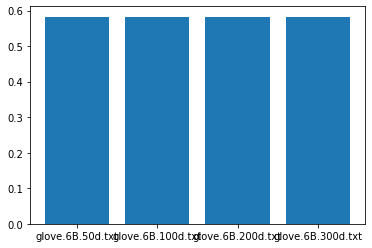

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def label_data(x):
  if x == "sports":
    return 1
  else:
    return 0
train_labels = train.root_label.apply(label_data)
test_labels = test.root_label.apply(label_data)

accs = []
fnames = ["glove.6B.50d.txt", "glove.6B.100d.txt", "glove.6B.200d.txt", "glove.6B.300d.txt"]
for fname in fnames:
  vectorized_train, vectorized_test = get_train_and_test(fname)
  classifier = SVC(C=10, kernel='linear').fit(vectorized_train, train_labels)
  preds = classifier.predict(vectorized_test)
  accs.append(accuracy_score(test_labels, preds))

import matplotlib.pyplot as plt
plt.bar(fnames, accs)

# Question 13

In [ ]:
!pip install umap-learn

In [42]:
!pip install umap-learn
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(vectorized_train)
print(embedding.shape)

(2520, 2)


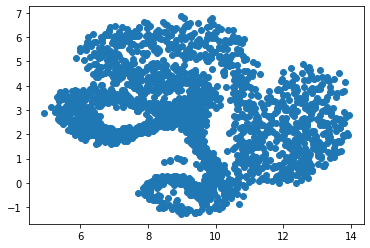

In [43]:
plt.scatter(embedding[:,0], embedding[:,1])